- look into architechture modification and add numerical values as concatenation

https://sbert.net/docs/sentence_transformer/training_overview.html#dataset-format

### Evaluation of model performance

In [1]:
%pip install accelerate==0.27.2
%pip install sentence-transformers
%pip install umap-learn
#%pip install cleodata --extra-index-url "https://aws:$(aws codeartifact get-authorization-token --domain meetcleo --domain-owner 878877078763 --query authorizationToken --output text)@meetcleo-878877078763.d.codeartifact.us-east-1.amazonaws.com/pypi/meetcleo-releases/simple/"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install awswrangler
%pip install --upgrade sentence_transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import awswrangler as wr
import boto3
from botocore.exceptions import ClientError
from io import StringIO
#from fastparquet import ParquetFile
#boto3.setup_default_session(profile_name='DataScientist-878877078763')
# from cleodata.utils.secrets import get_secret
#from cleodata.sources.sync.sync import SyncDataSource
#redshift_source = SyncDataSource("data_exploration", use_redshift=True, redshift_cluster="cleo-production-redshift", redshift_db="cleo")

In [2]:
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
import umap
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses
from sklearn.model_selection import train_test_split

2024-06-04 22:20:41.705271: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 22:20:41.989316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-14_2024-05-14_top_2001.parquet"
df_data_raw = wr.s3.read_parquet(path=s3_path)
df_data_raw.shape

(1691281, 8)

In [6]:
print(torch.cuda.device_count())

1


In [7]:
df_data_raw.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label
0,9800644268,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*AR...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*AR...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*AR...,Cash App,Apple,0,0.004783
1,9806843022,CASH APP*ROBERT BUCK*CA San FranciscoCA. Chann...,CASH APP*ROBERT BUCK*CA San FranciscoCA. Type:...,CASH APP*ROBERT BUCK*CA San FranciscoCA,Cash App,Zelle,0,0.368781
2,9800261931,CASH APP*ARLIN 05/14 #XXXXX PMNT RCVD CASH APP...,CASH APP*ARLIN 05/14 #XXXXX PMNT RCVD CASH APP...,CASH APP*ARLIN 05/14 #XXXXX PMNT RCVD CASH APP...,Cash App,Wells Fargo,0,0.214896
3,9792511116,DEBIT CARD DEBIT / auth # 05-14- CASH APP*JERE...,DEBIT CARD DEBIT / auth # 05-14- CASH APP*JERE...,DEBIT CARD DEBIT / auth # 05-14- CASH APP*JERE...,Cash App,Bread Financial,0,0.023041
4,9796579359,CASH APP*D WEEMS*CASH SAN FRANCISCOUS. Channel...,CASH APP*D WEEMS*CASH SAN FRANCISCOUS. Type: p...,CASH APP*D WEEMS*CASH SAN FRANCISCOUS,Cash App,Geneva Pit Stop,0,0.135050


In [8]:
#%pip install s3fs --upgrade
#import s3fs

In [9]:
df_ , df_test, y_, y_test = train_test_split(df_data_raw, df_data_raw['true_label'], test_size = 0.05, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_, df_['true_label'], test_size = 0.1, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(df_train.shape[0], df_val.shape[0], df_test.shape[0])

1446044 160672 84565


In [10]:
print(len(list(set(df_train['true_merchant_name_combined']))))
print(len(list(set(df_train['merchant_name_combined']))))

2001
96616


In [11]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from sentence_transformers.losses import CoSENTLoss
from datasets import Dataset
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers import SentenceTransformerTrainer

In [13]:
df_test.reset_index(drop=True, inplace=True)
ds_test = Dataset.from_pandas(df_test[['true_label','sentence','merchant_name_combined']])
ds_test = ds_test.rename_columns({"true_label": "score","sentence":"sentence1", "merchant_name_combined":"sentence2"})

https://medium.com/@divyansh9144/how-to-download-an-entire-amazon-s3-bucket-fe81c33fc03b

bucket = "cleo-data-science"

path_to_model = "transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/"

In [14]:
!ls models/model1/

checkpoint-500	checkpoint-600	runs


In [15]:
!ls models/model2/

checkpoint-1200  checkpoint-1400  checkpoint-1600  runs


In [4]:
# model = SentenceTransformer("./models/model1/checkpoint-600/")
# model = SentenceTransformer("models/model2/checkpoint-800/")
model = SentenceTransformer("models/model2/checkpoint-1600/")
#model = SentenceTransformer("models/model2/checkpoint-1600/")

In [ ]:
from sentence_transformers.evaluation import TripletEvaluator, BinaryClassificationEvaluator

In [ ]:
dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=df_test["sentence"],
    sentences2=df_test["true_merchant_name_combined"],
    scores=df_test["true_label"],
    main_similarity=SimilarityFunction.COSINE,
    name="sts-dev",
)

In [ ]:
# results = dev_evaluator(model)
# results


{'sts-dev_pearson_cosine': -0.048526771846859384,
 'sts-dev_spearman_cosine': -0.03247334289040431,
 'sts-dev_pearson_manhattan': -0.054131726512542756,
 'sts-dev_spearman_manhattan': -0.03755684252281118,
 'sts-dev_pearson_euclidean': -0.05538235003285581,
 'sts-dev_spearman_euclidean': -0.039942165997982663,
 'sts-dev_pearson_dot': -0.049363136459950455,
 'sts-dev_spearman_dot': -0.0332856602561397,
 'sts-dev_pearson_max': -0.048526771846859384,
 'sts-dev_spearman_max': -0.03247334289040431}

In [ ]:
#write my own Evaluator


In [ ]:
#split merchants and performance metrics for 
# top 80% of traffic
# top 90%
# top 95% of traffic

# Base these performance metrics on the traffic for a test day 

In [ ]:
df_test.shape

(84565, 10)

In [ ]:
df_test['true_merchant_name_combined'].nunique()

1977

In [ ]:
list_unique_merchants = df_train['true_merchant_name_combined'].unique()
print(f"Number of unique merchant {len(list_unique_merchants)}")
embeddings_merchants = model.encode(list_unique_merchants)
embeddings_merchants.shape

Number of unique merchant 2001


(2001, 768)

In [ ]:
batch_size = 1000
for istart in np.arange(0, df_test.shape[0]+1, batch_size):
    iend = min(df_test.shape[0],istart + batch_size)
    if iend> istart:
        print(istart, iend)
        tx_embeddings = model.encode(df_test['sentence'][istart:iend].tolist())
        similarities = model.similarity(tx_embeddings, embeddings_merchants)
        print(similarities.shape)
        max_vals = torch.max(similarities, axis=1)
        max_probs = max_vals[0]
        ix_max_merchants = max_vals[1]
        predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
        df_test.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
        df_test.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)

0 1000
torch.Size([1000, 2001])
1000 2000
torch.Size([1000, 2001])
2000 3000
torch.Size([1000, 2001])
3000 4000
torch.Size([1000, 2001])
4000 5000
torch.Size([1000, 2001])
5000 6000
torch.Size([1000, 2001])
6000 7000
torch.Size([1000, 2001])
7000 8000
torch.Size([1000, 2001])
8000 9000
torch.Size([1000, 2001])
9000 10000
torch.Size([1000, 2001])
10000 11000
torch.Size([1000, 2001])
11000 12000
torch.Size([1000, 2001])
12000 13000
torch.Size([1000, 2001])
13000 14000
torch.Size([1000, 2001])
14000 15000
torch.Size([1000, 2001])
15000 16000
torch.Size([1000, 2001])
16000 17000
torch.Size([1000, 2001])
17000 18000
torch.Size([1000, 2001])
18000 19000
torch.Size([1000, 2001])
19000 20000
torch.Size([1000, 2001])
20000 21000
torch.Size([1000, 2001])
21000 22000
torch.Size([1000, 2001])
22000 23000
torch.Size([1000, 2001])
23000 24000
torch.Size([1000, 2001])
24000 25000
torch.Size([1000, 2001])
25000 26000
torch.Size([1000, 2001])
26000 27000
torch.Size([1000, 2001])
27000 28000
torch.Size(

In [ ]:
print(df_test['true_merchant_name_combined'].nunique())
print(df_test['pred_merchant'].nunique())

1977
1922


In [ ]:
df_test.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9798082487,ALLY ALLY PAYMT keanna clark. Channel: None. A...,ALLY ALLY PAYMT keanna clark. Type: financial_...,ALLY ALLY PAYMT keanna clark,Ally Bank,Ally Bank,1,0.985237,Ally Bank,0.904120
1,9804841072,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,Lyft,MoneyLion,0,0.260391,Lyft,0.939527
2,9799411489,"PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...","PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...","PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...",Credit One Bank,23 Liquor,0,0.253272,Credit One Bank,0.834571
3,9800247899,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,Solitaire Cash,Buffalo Wild Wings,0,0.252959,Solitaire Cash,0.884843
4,9798407232,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,Apple Cash,Uber,0,0.075716,Apple Cash,0.802957


In [ ]:
test_unique_true_merchants = df_test['true_merchant_name_combined'].nunique()
test_unique_pred_merchants = df_test['pred_merchant'].nunique()
print(test_unique_true_merchants )
print(test_unique_pred_merchants )

1977
1922


In [ ]:
len(set(df_test['true_merchant_name_combined'].unique()).intersection(set(df_test['pred_merchant'].unique())))

1915

In [ ]:
df_test.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9798082487,ALLY ALLY PAYMT keanna clark. Channel: None. A...,ALLY ALLY PAYMT keanna clark. Type: financial_...,ALLY ALLY PAYMT keanna clark,Ally Bank,Ally Bank,1,0.985237,Ally Bank,0.904120
1,9804841072,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,Lyft,MoneyLion,0,0.260391,Lyft,0.939527
2,9799411489,"PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...","PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...","PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...",Credit One Bank,23 Liquor,0,0.253272,Credit One Bank,0.834571
3,9800247899,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,Solitaire Cash,Buffalo Wild Wings,0,0.252959,Solitaire Cash,0.884843
4,9798407232,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,Apple Cash,Uber,0,0.075716,Apple Cash,0.802957


In [ ]:
th_vec, prec_vec, recall_vec = [], [], []
for th in np.arange(0.1, 1, 0.05):
    df_filtered = df_test[df_test['pred_prob']>=th]
    n_filt = df_filtered.shape[0]
    true_positives = df_filtered[df_filtered['true_merchant_name_combined'] == df_filtered['pred_merchant']].shape[0]
    false_negatives = df_filtered[df_filtered['true_merchant_name_combined'] != df_filtered['pred_merchant']].shape[0]
    #precision = tp /tp + fp
    precision = true_positives/n_filt
    #recall = tp /tp + fn
    
    recall = true_positives/df_test.shape[0]
    th_vec.append(th)
    prec_vec.append(precision)
    recall_vec.append(recall)
    print(f"th {th:.2f}, precision {precision:.4f}, recall {recall:.4f}")

th 0.10, precision 0.9093, recall 0.9093
th 0.15, precision 0.9093, recall 0.9093
th 0.20, precision 0.9093, recall 0.9093
th 0.25, precision 0.9093, recall 0.9093
th 0.30, precision 0.9093, recall 0.9093
th 0.35, precision 0.9093, recall 0.9093
th 0.40, precision 0.9094, recall 0.9093
th 0.45, precision 0.9098, recall 0.9091
th 0.50, precision 0.9106, recall 0.9087
th 0.55, precision 0.9119, recall 0.9078
th 0.60, precision 0.9131, recall 0.9055
th 0.65, precision 0.9145, recall 0.9015
th 0.70, precision 0.9163, recall 0.8904
th 0.75, precision 0.9188, recall 0.8783
th 0.80, precision 0.9218, recall 0.8462
th 0.85, precision 0.9239, recall 0.7587
th 0.90, precision 0.9205, recall 0.5097
th 0.95, precision 0.9089, recall 0.0254


In [176]:
import matplotlib.pyplot as plt

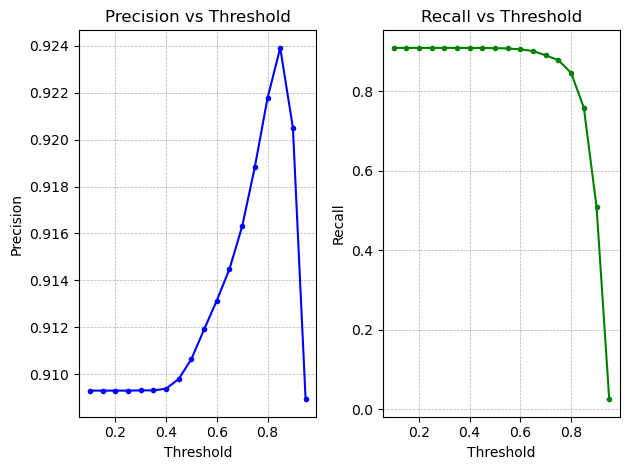

In [177]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2)  # Create a 1x2 grid of subplots

# Plot on the first subplot
axs[0].plot(th_vec, prec_vec, 'b.-')
axs[0].set_title('Precision vs Threshold')  # Optional: set the title
axs[0].set_xlabel('Threshold')  # Optional: set the x-axis label
axs[0].set_ylabel('Precision')  # Optional: set the y-axis label
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot on the second subplot
axs[1].plot(th_vec, recall_vec, 'g.-')
axs[1].set_title('Recall vs Threshold')  # Optional: set the title
axs[1].set_xlabel('Threshold')  # Optional: set the x-axis label
axs[1].set_ylabel('Recall')  # Optional: set the y-axis label
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

### Very confident mistakes could be a good indication of duplicates

In [185]:
#Lets look at the sure cases that were wrong
df_confident_mistakes =  df_test[(df_test['pred_prob']>=0.95) & (df_test['true_merchant_name_combined']!= df_test['pred_merchant'])]
df_confident_mistakes.drop('merchant_name_combined', axis = 1)[0:50]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,true_label,label,pred_merchant,pred_prob
420,9790821350,"KLOVER APP BOOST, FUNDING , O7H5UBCJNJIFW8W. C...","KLOVER APP BOOST, FUNDING , O7H5UBCJNJIFW8W. T...","KLOVER APP BOOST, FUNDING , O7H5UBCJNJIFW8W",Klover App,1,0.963167,Kloverplus,0.956848
1893,9799141796,PURCHASE RETURN AUTHORIZED ON 05/12 DOORDASH D...,PURCHASE RETURN AUTHORIZED ON 05/12 DOORDASH D...,PURCHASE RETURN AUTHORIZED ON 05/12 DOORDASH D...,DoorDash,1,0.838886,Dashpass Www.doordash.,0.963499
2336,9802355939,NNT MICROSOFT*ULTIM172 MSBILL.INFO WA 05/15. C...,NNT MICROSOFT*ULTIM172 MSBILL.INFO WA 05/15. T...,NNT MICROSOFT*ULTIM172 MSBILL.INFO WA 05/15,Microsoft Xbox,1,0.823143,Microsoft,0.950414
3034,9800061893,RECURRING PAYMENT AUTHORIZED ON 05/12 GOOGLE *...,RECURRING PAYMENT AUTHORIZED ON 05/12 GOOGLE *...,RECURRING PAYMENT AUTHORIZED ON 05/12 GOOGLE *...,YouTube,0,0.062978,Youtube G.co,0.958066
3080,9802012042,PURCHASE AUTHORIZED ON 05/13 KLOVER PLUS Chica...,PURCHASE AUTHORIZED ON 05/13 KLOVER PLUS Chica...,PURCHASE AUTHORIZED ON 05/13 KLOVER PLUS Chica...,Klover App,1,0.909512,Kloverplus,0.950089
3227,9798489844,KLOVER APP BOOST DDA POS PURCHASE CD . Channel...,KLOVER APP BOOST DDA POS PURCHASE CD . Type: f...,KLOVER APP BOOST DDA POS PURCHASE CD,Klover App,1,0.987475,Kloverplus,0.954104
3290,9799294810,GOOGLE *YouTube Vi 05-13 g.co/helppay# CA DEBI...,GOOGLE *YouTube Vi 05-13 g.co/helppay# CA DEBI...,GOOGLE *YouTube Vi 05-13 g.co/helppay# CA DEBI...,YouTube,0,0.057820,Youtube G.co,0.957141
3415,9802127848,RECURRING PAYMENT AUTHORIZED ON 05/13 DOORDASH...,RECURRING PAYMENT AUTHORIZED ON 05/13 DOORDASH...,RECURRING PAYMENT AUTHORIZED ON 05/13 DOORDASH...,DoorDash,1,0.931369,Dashpass Www.doordash.,0.964374
3913,9944112225,PURCHASE AUTHORIZED ON 05/13 bet365.AZ 833- NJ...,PURCHASE AUTHORIZED ON 05/13 bet365.AZ 833- NJ...,PURCHASE AUTHORIZED ON 05/13 bet365.AZ 833- NJ...,Bet365.az,1,0.581349,Bet365.nc,0.966322
4107,9797852489,KLOVER APP BOOST Chicago IL - POS/WDR . Channe...,KLOVER APP BOOST Chicago IL - POS/WDR . Type: ...,KLOVER APP BOOST Chicago IL - POS/WDR,Klover App,1,0.862197,Kloverplus,0.954017


### Look at uncofident predictions

In [223]:
#Lets look at the sure cases that were wrong
df_uncofident_mistakes =  df_test[(df_test['pred_prob']<0.6) & (df_test['true_merchant_name_combined']!= df_test['pred_merchant'])]
df_uncofident_mistakes.sort_values(by='pred_prob', ascending=False, inplace=True)
df_uncofident_mistakes.reset_index(drop=True, inplace=True)
df_uncofident_mistakes.drop('merchant_name_combined', axis = 1)[0:50]

/home/sagemaker-user/.tmp/ipykernel_25467/245688496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uncofident_mistakes.sort_values(by='pred_prob', ascending=False, inplace=True)


,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9783053147,TST 123 PHO. Channel: in store. Amount: -18.08...,TST 123 PHO. Type: merchant. Channel: in store...,TST 123 PHO,PHO,0,0.135154,Toast,0.599460
1,9798981779,PAYPAL INST XFER REF # PAYPAL PAYPALSI77INST X...,PAYPAL INST XFER REF # PAYPAL PAYPALSI77INST X...,PAYPAL INST XFER REF # PAYPAL PAYPALSI77INST X...,Uber Eats,0,0.126178,Food,0.599248
2,9806152998,PURCHASE AUTHORIZED ON 05/14 MARCONI EXPRESS M...,PURCHASE AUTHORIZED ON 05/14 MARCONI EXPRESS M...,PURCHASE AUTHORIZED ON 05/14 MARCONI EXPRESS M...,Express Mart,1,0.698871,Marco''s Pizza,0.599184
3,9799813136,eTransfer 05/13 18:27 800-205- ZELLE DAYLE MCN...,eTransfer 05/13 18:27 800-205- ZELLE DAYLE MCN...,eTransfer 05/13 18:27 800-205- ZELLE DAYLE MCNAB,Zelle,0,0.048514,Etsy,0.598805
4,9791639341,Round-up Credit from Purchase DD DOORDASH BABA...,Round-up Credit from Purchase DD DOORDASH BABA...,Round-up Credit from Purchase DD DOORDASH BABA...,DoorDash,1,0.753179,Doordashca,0.598138
5,9800203768,DBT CRD DD DOORDASH THEHUMANB 855-973- CA C# ....,DBT CRD DD DOORDASH THEHUMANB 855-973- CA C# ....,DBT CRD DD DOORDASH THEHUMANB 855-973- CA C#,The Human Bean,0,0.181895,DoorDash,0.597803
6,9798732711,05-13-24 SEVIERVILLE TN THEHOME DEPOT # DEBIT ...,05-13-24 SEVIERVILLE TN THEHOME DEPOT # DEBIT ...,05-13-24 SEVIERVILLE TN THEHOME DEPOT # DEBIT ...,The Home Depot,1,0.926287,Office Depot,0.597600
7,9800261022,Total Card GT PAYMENT Alicia Bernard. Channel:...,Total Card GT PAYMENT Alicia Bernard. Type: me...,Total Card GT PAYMENT Alicia Bernard,Total,1,0.812245,TOTAL Visa,0.596814
8,9804092941,DEBIT CARD PURCHASE XXXXX DD *DOORDASH ROCKMAR...,DEBIT CARD PURCHASE XXXXX DD *DOORDASH ROCKMAR...,DEBIT CARD PURCHASE XXXXX DD *DOORDASH ROCKMAR...,DoorDash,1,0.945692,Rock Auto,0.595978
9,9801741204,AV WELLBEING LIM IAT PAYPAL MOISES CRUZ JAUREG...,AV WELLBEING LIM IAT PAYPAL MOISES CRUZ JAUREG...,AV WELLBEING LIM IAT PAYPAL MOISES CRUZ JAUREGUI,PayPal,1,0.992255,Avis,0.595930


### Find the best candidates for the uncofident predictions

In [224]:
tx_description = df_uncofident_mistakes.loc[0,'description_combined_processed']
tx_description

'TST 123 PHO'

In [225]:
tx_embeddings = model.encode(tx_description)
similarities = model.similarity(tx_embeddings, embeddings_merchants)
print(similarities.shape)
max_vals = torch.max(similarities, axis=1)
max_probs = max_vals[0]

torch.Size([1, 2001])


In [226]:
similarities

tensor([[ 0.1724,  0.1842, -0.0244,  ...,  0.0765,  0.1238,  0.1253]])

In [228]:
top_values, top_indices = torch.topk(similarities.flatten(), 10)
print(top_values)
print(top_indices)
[list_unique_merchants[i] for i in top_indices]

tensor([0.5791, 0.4451, 0.4357, 0.4353, 0.4352, 0.4311, 0.4304, 0.4300, 0.4264,
        0.4236])
tensor([  80,  865, 1694, 1537, 1177, 1878, 1154, 1526, 1751,  419])


['Toast',
 'Moon',
 "Chuy''s",
 'Spin X Games',
 'Cold Stone Creamery',
 'PHO',
 'Crh Catering Co',
 "Qik''n EZ",
 'Convenience',
 'Moon Active']

### Train a re-reanker, 

If the certainty is low, pass it through a re-ranker


To create a dataset, take the top 10 candidates for each description

trx_id, tx_descr, cand1, label

In [63]:
df_test

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9798082487,ALLY ALLY PAYMT keanna clark. Channel: None. A...,ALLY ALLY PAYMT keanna clark. Type: financial_...,ALLY ALLY PAYMT keanna clark,Ally Bank,Ally Bank,1,0.985237,Earnin,0.408486
1,9804841072,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,Lyft,MoneyLion,0,0.260391,McDonald''s,0.420442
2,9799411489,"PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...","PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...","PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...",Credit One Bank,23 Liquor,0,0.253272,Wells Fargo,0.842252
3,9800247899,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,Solitaire Cash,Buffalo Wild Wings,0,0.252959,Cash App,0.837808
4,9798407232,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,Apple Cash,Uber,0,0.075716,Cash App,0.858146
...,...,...,...,...,...,...,...,...,...,...
84560,9798569849,Pos Debit- Empower Advance Empower.me CA. Chan...,Pos Debit- Empower Advance Empower.me CA. Type...,Pos Debit- Empower Advance Empower.me CA,Empower,Inc Katelynn Fletcher,0,0.143810,Amazon,0.503931
84561,9797827093,Purchase DOLLAR GENERAL # MOUNT PLEASANMIUS. C...,Purchase DOLLAR GENERAL # MOUNT PLEASANMIUS. T...,Purchase DOLLAR GENERAL # MOUNT PLEASANMIUS,Dollar General,Meta Pay,0,0.044711,McDonald''s,0.543378
84562,9800675621,PNC BANK 05/14 #XXXXX WITHDRWL CENTREVILLE MAN...,PNC BANK 05/14 #XXXXX WITHDRWL CENTREVILLE MAN...,PNC BANK 05/14 #XXXXX WITHDRWL CENTREVILLE MAN...,PNC,PNC,1,0.841737,Wells Fargo,0.880522
84563,9818778881,N PAYMENT POSMBGB1LNV EMPOWER SAN FRANCISC CA....,N PAYMENT POSMBGB1LNV EMPOWER SAN FRANCISC CA....,N PAYMENT POSMBGB1LNV EMPOWER SAN FRANCISC CA,Empower,Maverik,0,0.123350,Amazon,0.472923


In [69]:
df_test_conf = df_test[df_test['pred_prob']>0.9]
df_test_conf.reset_index(drop=True, inplace=True)
df_test_conf
#[['sentence','true_merchant_name_combined','pred_merchant','pred_prob']]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9793352507,CASH APP*ASHAWNTE W*AD. Channel: None. Amount:...,CASH APP*ASHAWNTE W*AD. Type: payment_app. Cha...,CASH APP*ASHAWNTE W*AD,Cash App,Grand Liquor,0,0.054893,Cash App,0.972727
1,9809433389,PURCHASE AUTHORIZED ON 05/13 Prime Video Chann...,PURCHASE AUTHORIZED ON 05/13 Prime Video Chann...,PURCHASE AUTHORIZED ON 05/13 Prime Video Chann...,Amazon Prime Video,Dlr Small World Toy,0,0.123169,Amazon,0.912112
2,9796657789,Withdrawal Debit Prime Video Channels amzn.com...,Withdrawal Debit Prime Video Channels amzn.com...,Withdrawal Debit Prime Video Channels amzn.com...,Amazon Prime Video,Amazon Prime Video,1,0.948757,Amazon,0.931546
3,9802010635,ONLINE TRANSFER FROM TRANQUILLE E WAY2SAVE SAV...,ONLINE TRANSFER FROM TRANQUILLE E WAY2SAVE SAV...,ONLINE TRANSFER FROM TRANQUILLE E WAY2SAVE SAV...,Wells Fargo,Apple,0,0.248670,Wells Fargo,0.963938
4,9804214439,Mobile Purchase Sign Based 05/10 08:30a # D Kl...,Mobile Purchase Sign Based 05/10 08:30a # D Kl...,Mobile Purchase Sign Based 05/10 08:30a # D Kl...,Klarna,Klarna,1,0.961299,Amazon,0.928806
...,...,...,...,...,...,...,...,...,...,...
6016,9799050306,Withdrawal or Check Credit One Bank Payment . ...,Withdrawal or Check Credit One Bank Payment . ...,Withdrawal or Check Credit One Bank Payment,Credit One Bank,Bank of America,0,0.055547,Wells Fargo,0.902997
6017,9804026312,Earnin DES:TRANSFER ID:XXXXX INDN:Christopher ...,Earnin DES:TRANSFER ID:XXXXX INDN:Christopher ...,Earnin DES:TRANSFER ID:XXXXX INDN:Christopher ...,Earnin,Buc-ee''s,0,0.179977,Earnin,0.966794
6018,9811680024,PURCHASE AUTHORIZED ON 05/13 AMZN Mktp US*UO5M...,PURCHASE AUTHORIZED ON 05/13 AMZN Mktp US*UO5M...,PURCHASE AUTHORIZED ON 05/13 AMZN Mktp US*UO5M...,Amazon,Amazon,1,0.877650,Amazon,0.956834
6019,9884241805,REAL TIME PAYMENT CREDIT RECD FROM ABA/CONTR B...,REAL TIME PAYMENT CREDIT RECD FROM ABA/CONTR B...,REAL TIME PAYMENT CREDIT RECD FROM ABA/CONTR B...,Earnin,Earnin,1,0.946142,Earnin,0.939578


In [70]:
df_test_conf.loc[4,'description_combined_processed']

'Mobile Purchase Sign Based 05/10 08:30a # D Klarna*amazon Columbus OH 24'

In [58]:
ntrue = df_test[df_test['pred_merchant'] == df_test['true_merchant_name_combined']].shape[0]

precision = ntrue/df_test.shape[0]
print(precision)

0.061278306628037606


In [59]:
df_test

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9798082487,ALLY ALLY PAYMT keanna clark. Channel: None. A...,ALLY ALLY PAYMT keanna clark. Type: financial_...,ALLY ALLY PAYMT keanna clark,Ally Bank,Ally Bank,1,0.985237,Earnin,0.408486
1,9804841072,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,Lyft,MoneyLion,0,0.260391,McDonald''s,0.420442
2,9799411489,"PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...","PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...","PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...",Credit One Bank,23 Liquor,0,0.253272,Wells Fargo,0.842252
3,9800247899,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,Solitaire Cash,Buffalo Wild Wings,0,0.252959,Cash App,0.837808
4,9798407232,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,Apple Cash,Uber,0,0.075716,Cash App,0.858146
...,...,...,...,...,...,...,...,...,...,...
84560,9798569849,Pos Debit- Empower Advance Empower.me CA. Chan...,Pos Debit- Empower Advance Empower.me CA. Type...,Pos Debit- Empower Advance Empower.me CA,Empower,Inc Katelynn Fletcher,0,0.143810,Amazon,0.503931
84561,9797827093,Purchase DOLLAR GENERAL # MOUNT PLEASANMIUS. C...,Purchase DOLLAR GENERAL # MOUNT PLEASANMIUS. T...,Purchase DOLLAR GENERAL # MOUNT PLEASANMIUS,Dollar General,Meta Pay,0,0.044711,McDonald''s,0.543378
84562,9800675621,PNC BANK 05/14 #XXXXX WITHDRWL CENTREVILLE MAN...,PNC BANK 05/14 #XXXXX WITHDRWL CENTREVILLE MAN...,PNC BANK 05/14 #XXXXX WITHDRWL CENTREVILLE MAN...,PNC,PNC,1,0.841737,Wells Fargo,0.880522
84563,9818778881,N PAYMENT POSMBGB1LNV EMPOWER SAN FRANCISC CA....,N PAYMENT POSMBGB1LNV EMPOWER SAN FRANCISC CA....,N PAYMENT POSMBGB1LNV EMPOWER SAN FRANCISC CA,Empower,Maverik,0,0.123350,Amazon,0.472923


In [60]:
ntrue = df_test[(df_test['pred_merchant'] == df_test['true_merchant_name_combined']) & (df_test['pred_prob']>=0.8)].shape[0]

accuracy = ntrue/df_test.shape[0]
print(accuracy)

0.05212558387039555


In [61]:
#tp/tp + fp
df_no_match = df_test[df_test['pred_merchant'] != df_test['true_merchant_name_combined']]
df_no_match.reset_index(drop=True, inplace=True)
df_no_match.shape[0]

79383

In [63]:

df_no_match.drop_duplicates(subset = ['true_merchant_name_combined','pred_merchant']).shape[0]

6224

In [118]:
df_no_match.drop_duplicates(subset = ['true_merchant_name_combined','pred_merchant'])

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9796686754,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Channe...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Type: ...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO,Walmart,Smith''s,0,0.310292,Wal Wal-martsuper,0.799137
13,9799066977,ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CL...,ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CL...,ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CL...,Wells Fargo,Empower,0,0.416453,McDonald''s,0.939226
18,9813217231,POS PURCHASE POS WM SUPERCENTER GREENVILLE PA....,POS PURCHASE POS WM SUPERCENTER GREENVILLE PA....,POS PURCHASE POS WM SUPERCENTER GREENVILLE PA,Walmart,RaceTrac,0,0.288263,McDonald''s,0.630497
36,9795670664,POS PURCH : WM SUPERCENTER # GA BAXLEY WM SUPE...,POS PURCH : WM SUPERCENTER # GA BAXLEY WM SUPE...,POS PURCH : WM SUPERCENTER # GA BAXLEY WM SUPE...,Walmart,Synchrony,0,0.000095,U.s. Retailers,0.642287
269,9800470341,ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMAR...,ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMAR...,ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMART,Walmart,Bank of America,0,0.030782,Zelle,0.705138


In [122]:
df_no_match.loc[13,'sentence']

'ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CLEAR ACCESS BANKING XXXXXX REF #IB0N78QNRB ON 05/14/24. Channel: None. Amount: 90.0'

In [120]:
df_no_match.loc[269,'sentence']

'ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMART. Channel: None. Amount: -98.77'

In [109]:
# do a precision-recall curve

In [80]:
df_train['true_merchant_name_combined'].value_counts()

true_merchant_name_combined
Amazon         12848
Cash App       12840
Earnin         12825
Wells Fargo    12812
McDonald''s    12811
Zelle          12781
Walmart         8583
Name: count, dtype: Int64

In [81]:
df_train['true_merchant_name_combined'].nunique()

7

In [78]:
df_test['true_merchant_name_combined'].value_counts()

true_merchant_name_combined
Zelle          796
Wells Fargo    757
Amazon         756
Cash App       746
McDonald''s    745
Earnin         729
Walmart        471
Name: count, dtype: Int64

In [79]:
df_val['true_merchant_name_combined'].value_counts()

true_merchant_name_combined
Earnin         1446
McDonald''s    1444
Wells Fargo    1431
Zelle          1423
Cash App       1414
Amazon         1396
Walmart         946
Name: count, dtype: Int64

In [76]:
df_test[['true_merchant_name_combined','pred_merchant','pred_prob']]

,true_merchant_name_combined,pred_merchant,pred_prob
0,Wells Fargo,Wells Fargo,0.961568
1,McDonald''s,McDonald''s,0.974988
2,Cash App,Cash App,0.975234
3,McDonald''s,McDonald''s,0.980123
4,Walmart,Wal Wal-martsuper,0.799137
...,...,...,...
4995,Wells Fargo,Wells Fargo,0.940395
4996,Zelle,Zelle,0.979735
4997,Walmart,Wal Wal-martsuper,0.674671
4998,Zelle,Zelle,0.980085


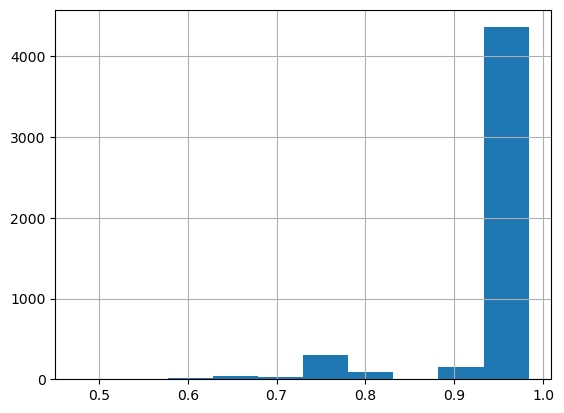

In [85]:
df_test['pred_prob'].hist();

In [89]:
df_test[df_test['pred_prob']<0.85][:500]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
4,9796686754,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Channe...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Type: ...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO,Walmart,Smith''s,0,0.310292,Wal Wal-martsuper,0.799137
11,9799290885,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Synchrony,0,0.232759,Wal Wal-martsuper,0.775473
12,9798904474,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart,QuikTrip,0,0.075148,Wal Wal-martsuper,0.751793
17,9801927063,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,Walmart,Cash App,0,0.078535,Wal Wal-martsuper,0.735269
28,9799263021,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT,Walmart,Marathon Petroleum,0,0.257865,Wal Wal-martsuper,0.751371
...,...,...,...,...,...,...,...,...,...,...
4960,9807244423,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Spinstersis,0,0.051089,Wal Wal-martsuper,0.772779
4965,9808452776,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart,K Stop Convenience,0,0.018743,Wal Wal-martsuper,0.713919
4971,9798778036,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Walmart,Ross Stores,0,0.114881,Wal Wal-martsuper,0.766499
4981,9807593604,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,Walmart,Lyft,0,0.116438,Wal Wal-martsuper,0.751746


In [51]:
df_test.shape

(5000, 10)

In [53]:
df_test['sentence'][100:150]

100    Deposit Debit Ca Earnin CEEEE_B Palo Alto CA D...
101    Zelle payment from AMY HAYES for \"vanishing b...
102    EARNIN CHGFC_B PALO ALTO CA 05/14. Channel: No...
103    PURCHASE AUTHORIZED ON 05/13 MCDONALD''S F IRV...
104    Debit Card Credit EARNIN CCHGA_B PALO ALTO CA....
105    Zelle payment from SUSAN BRODBECK BACsggj269q0...
106    POS Payment McDonalds 154-XXX VA # . Channel: ...
107    ONLINE TRANSFER FROM HUDSON A WAY2SAVE SAVINGS...
108    EARNIN CDHJA_B PALO ALTO CA 05/14. Channel: No...
109    Earnin CEGJA_B Palo Alto CA. Channel: None. Am...
110    ONLINE TRANSFER FROM BENNETT T WAY2SAVE SAVING...
111    Zelle payment from ALEXIS GAUDET BACxe32r3prx....
112    PURCHASE AMZN Mktp US*SY1BN Amzn.com/billWA XX...
113    CASH APP*ERIC LOLA BAR. Channel: None. Amount:...
114    Zelle payment from SHAVONNE MORENO BACpwpbspl0...
115    McDonalds 05-12 BROOKSVILLE FL DEBIT CARD PURC...
116    CHECKCARD CASH APP*WE DESIG XXXXX CA XXXXX XXX...
117    AMZN Mktp US*WN8Q06S Amz

In [54]:
model.encode(df_test['sentence'][istart:istart+batch_size].tolist())

array([[-0.00816036,  0.27537555,  0.14324246, ...,  0.0999889 ,
        -0.0035936 ,  0.07809736],
       [ 0.02443847, -0.07863627,  0.01445072, ...,  0.02271993,
         0.03442278,  0.02410999],
       [-0.01848849,  0.26305526,  0.12530893, ...,  0.09496655,
         0.00565742,  0.07274164],
       ...,
       [ 0.02032459, -0.06118753,  0.01493401, ..., -0.00625443,
         0.10024939,  0.12695931],
       [-0.01988285, -0.1525213 ,  0.0045229 , ..., -0.01461221,
         0.02463034,  0.0660398 ],
       [-0.01051987, -0.06855395,  0.00723861, ..., -0.00558885,
         0.0144608 ,  0.05602989]], dtype=float32)

In [47]:
df_test.loc[istart:istart+batch_size-1,'pred_merchant'].shape

(100,)

In [46]:
df_test.loc[0:100,'label'].shape

(101,)

In [44]:
df_test[0:100].shape

(100, 10)

In [42]:
istart+batch_size

100

In [38]:

len(predicted_merchant)

100

In [19]:
tx_embedding = model.encode(df_test['sentence'][0:2])

In [20]:
tx_embedding.shape

(2, 768)

torch.Size([2, 85500])

torch.return_types.max(
values=tensor([0.9616, 0.9750]),
indices=tensor([117,  17]))

tensor([117,  17])

In [59]:
df_test['merchant_name_combined']

0         Wells Fargo
1         McDonald''s
2            Cash App
3             Verizon
4            Smith''s
            ...      
4995    Chumba Casino
4996            Zelle
4997           Crenco
4998          Empower
4999            Zelle
Name: merchant_name_combined, Length: 5000, dtype: string

In [2]:
matched_merchants = similarities.max(axis=1)
matched_merchants

NameError: name 'similarities' is not defined

In [240]:
similarity_score = matched_merchants[0]
similarity_score

tensor([0.9629, 0.9737])

In [1]:
matched_merchants

NameError: name 'matched_merchants' is not defined

Load model

In [163]:
print(sentence_transformers.__version__)

3.0.0


In [113]:
from sentence_transformers import SentenceTransformerModelCardData
from datasets import load_dataset


In [125]:
# 1. Load a model to finetune with 2. (Optional) model card data
model = SentenceTransformer(
    "microsoft/mpnet-base",
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name="MPNet base trained on AllNLI triplets",
    )
)

# 3. Load a dataset to finetune on
dataset = load_dataset("sentence-transformers/all-nli",'pair-score')

No sentence-transformers model found with name microsoft/mpnet-base. Creating a new one with mean pooling.
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split:   0%|          | 0/942069 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/19657 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19656 [00:00<?, ? examples/s]

In [126]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 942069
    })
    dev: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 19657
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 19656
    })
})

In [127]:
train_dataset = dataset['train']

In [128]:
train_dataset[0]

{'sentence1': 'A person on a horse jumps over a broken down airplane.',
 'sentence2': 'A person is training his horse for a competition.',
 'score': 0.5}

In [98]:
#train_dataloader = DataLoader(train_examples, shuffle=True, batch_size = 128)

In [38]:
len(train_dataloader)

668

In [96]:
#train_loss = losses.CosineSimilarityLoss(model)

In [97]:
train_loss

NameError: name 'train_loss' is not defined

## Tune the model

In [26]:
model.fit(train_objectives = [(train_dataloader, train_loss)], epochs = 1 , warmup_steps = 100)

Detected kernel version 4.14.343, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
500,0.020500


In [27]:
# save model

## Evaluation

In [28]:
trx_descriptions = df_val['sentence'].tolist()
merchants = df_val['merchant_name_combined'].tolist()
trx_embeddings = model.encode(trx_descriptions)
merchants_embeddings = model.encode(merchants)

In [29]:
print(trx_embeddings.shape)
print(merchants_embeddings.shape)

(9500, 768)
(9500, 768)


In [31]:
import numpy as np

In [33]:
## look into numba
cosine_similarity(trx_embeddings, merchants_embeddings).shape
df_val['cos_similarity']=np.diag(cosine_similarity(trx_embeddings, merchants_embeddings))

In [34]:
df_val

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,cos_similarity
0,9798760350,Debit Purchase Wal-mart Super Cbrookings Sd 05...,Debit Purchase Wal-mart Super Cbrookings Sd 05...,Debit Purchase Wal-mart Super Cbrookings Sd 05...,Walmart,Exotic S Shop,0,0.328529,0.000262
1,9806775557,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,Cash App,Acorns,0,0.265679,-0.010028
2,9798728894,MONEY TRANSFER AUTHORIZED ON 05/13 FROM Earnin...,MONEY TRANSFER AUTHORIZED ON 05/13 FROM Earnin...,MONEY TRANSFER AUTHORIZED ON 05/13 FROM Earnin...,Earnin,PayPal,0,0.207873,-0.003231
3,9799291124,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,Cash App,Wells Fargo,0,0.008904,0.001403
4,9799976650,Instant Pmt from Earnin RDBFA_B on 05/14 Ref# ...,Instant Pmt from Earnin RDBFA_B on 05/14 Ref# ...,Instant Pmt from Earnin RDBFA_B on 05/14 Ref# ...,Earnin,Venmo,0,0.054398,-0.010100
...,...,...,...,...,...,...,...,...,...
9495,9799636891,PURCHASE RETURN AUTHORIZED ON 05/13 AMZN Mktp ...,PURCHASE RETURN AUTHORIZED ON 05/13 AMZN Mktp ...,PURCHASE RETURN AUTHORIZED ON 05/13 AMZN Mktp ...,Amazon,TGI Friday''s,0,0.102636,0.001885
9496,9799365097,"AMZN Mktp US GE69A,2YL3 Amzn com WA,05-13-24,C...","AMZN Mktp US GE69A,2YL3 Amzn com WA,05-13-24,C...","AMZN Mktp US GE69A,2YL3 Amzn com WA,05-13-24,C...",Amazon,Amazon,1,0.840733,0.995985
9497,9814848095,ONLINE TRANSFER FROM NAME N WELLS FARGO CLEAR ...,ONLINE TRANSFER FROM NAME N WELLS FARGO CLEAR ...,ONLINE TRANSFER FROM NAME N WELLS FARGO CLEAR ...,Wells Fargo,Wells Fargo,1,0.888943,0.988127
9498,9799827250,MCDONALD''S F ROCKY RIVER OH 05/13. Channel: i...,MCDONALD''S F ROCKY RIVER OH 05/13. Type: merc...,MCDONALD''S F ROCKY RIVER OH 05/13,McDonald''s,Coca-Cola,0,0.085374,-0.001350


In [37]:
while True:
    pass

KeyboardInterrupt: 

In [ ]:
validate_data[['label', 'true_label','cos_similarity']]

In [ ]:
# reducer = umap.UMAP(n_epochs=400,  n_neighbors=150, min_dist=0.1)
# reducer.fit(merchants_embeddings
# )
# embedding_2d = reducer.transform(merchants_embeddings)
# fig = px.scatter(embedding_2d, x=0, y=1,opacity=0.05, height=500, hover_name=names)
# fig.show()